In [54]:
from pathlib import Path
import nibabel as nib
import numpy as np
from numpy import pi
from scipy import ndimage
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from typing import Callable, Union

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt 

import random
from pathlib import Path
from PIL import Image

from operator import itemgetter

from batchgenerators.dataloading.data_loader import SlimDataLoaderBase
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import MirrorTransform
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.transforms.spatial_transforms import SpatialTransform
from batchgenerators.transforms.abstract_transforms import RndTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform
from batchgenerators.transforms.noise_transforms import GaussianBlurTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.color_transforms import GammaTransform

import sys
sys.path.append('../src')
from utils import class2one_hot
sys.path.append('..')
from data_augmenter import CTImageDataset, load_ct_images_and_gts, plot_batch

In [55]:
root_dir = "../" / Path("data") / "SEGTHOR_MANUAL_SPLIT/augmented_train"


In [61]:
img = load_ct_images_and_gts(root_dir)

../data/SEGTHOR_MANUAL_SPLIT/augmented_train/img
../data/SEGTHOR_MANUAL_SPLIT/augmented_train/gt


In [62]:
different_shape_indices = [i for i, image in enumerate(img[0]) if image.shape != img[0][0].shape]
print("Indices of images with different shapes:", different_shape_indices)

Indices of images with different shapes: []


In [63]:
print(img[0][0].shape)

(256, 256)


In [64]:
batchgen = CTImageDataset(img[0], img[1], batch_size= 4, batch=True)

In [32]:
print(next(batchgen))

{'data': array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
   

In [65]:
def plot_batch(batch):
    """
    Visualize a batch of images and their ground truth.
    """
    batch_size = batch['data'].shape[0]
    plt.figure(figsize=(16, 10))
    for i in range(batch_size):
        plt.subplot(2, batch_size, i + 1)
        plt.imshow(batch['data'][i, 0], cmap="gray")  # Visualize input image
        plt.axis('off')
        plt.subplot(2, batch_size, batch_size + i + 1)
        plt.imshow(batch['seg'][i, 0], cmap="gray")  # Visualize GT
        plt.axis('off')
    plt.show()

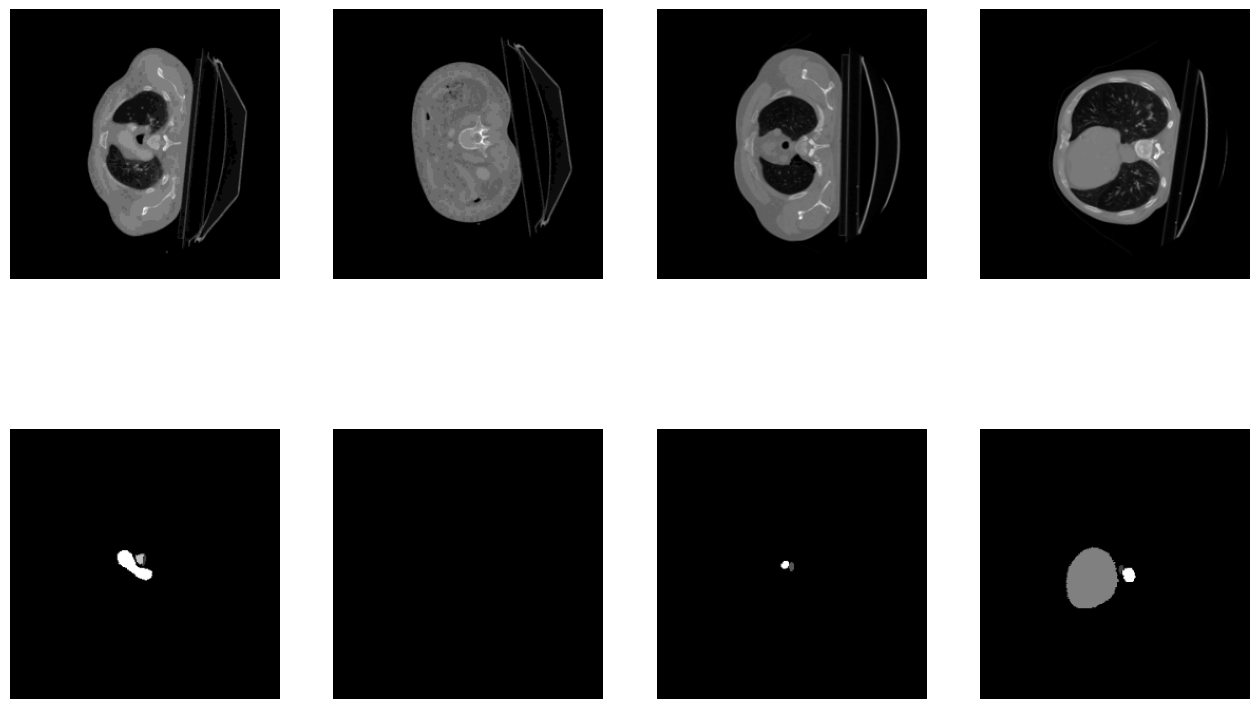

In [66]:
plot_batch(next(batchgen))

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def check_gt_for_labels(batch):
    seg_masks = batch['seg']
    count = 0
    for i, mask in enumerate(seg_masks):
        if not np.any(mask > 0):
            count+=1
            
    if count != 0:
        return False
    else:
        return True

def show_slices(batchgen, t):
    batch = next(batchgen)
    
    while check_gt_for_labels(batch) is False:
        batch = next(batchgen)

    print("Batch shape:", batch['data'].shape)
    indices = [*range(0, batch['data'].shape[0])]
    fig = plt.figure(figsize=(16, 6))
    
    # Create a subfigure structure: one subfigure for the images and one for the legend
    subfigs = fig.subfigures(1, 1)
    
    # Subfigure for the images
    axs = subfigs.subplots(1, len(indices))

    # Define colors for each class (excluding background)
    colors = ['red', 'green', 'blue', 'yellow']

    img = batch['data']
    gt1 = batch['seg']

    for i, idx in enumerate(indices):
        # Display the original image in grayscale
        axs[i].imshow(img[i, 0], cmap='gray')
        axs[i].axis('off')  # Remove axis for better visual

        # Create RGBA arrays for gt1 (segmentation)
        gt1_colored = np.zeros((*gt1[i, 0].shape, 4))

        color_labels = [0, 63, 126, 189, 252]
        for class_idx, color in enumerate(colors, start=1):
            mask1 = gt1[i, 0] == color_labels[class_idx]
            rgba_color = plt.cm.colors.to_rgba(color, alpha=0.5)
            gt1_colored[mask1] = rgba_color

        axs[i].imshow(gt1_colored)
        axs[i].axis('off')  # Remove axis for better visual

    # Create a subfigure for the legend and title
    subfigs.set_facecolor('white')

    # Create legend with color representation for each class
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='red', alpha=0.5),
        plt.Rectangle((0, 0), 1, 1, facecolor='green', alpha=0.5),
        plt.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.5),
        plt.Rectangle((0, 0), 1, 1, facecolor='yellow', alpha=0.5)
    ]

    # Add title and legend to the second subfigure
    subfigs.legend(
        legend_elements, 
        ["Esophagus", "Heart", "Trachea", "Aorta"], 
        loc="lower left", 
        ncol=4,
        fancybox=True, shadow=True, title = "GT segmentation:", fontsize=12, title_fontsize=12
    )

    # Add the title at the top of the first subfigure
    subfigs.suptitle(f"CT scan and GT segmentation with {t} data augmentation", fontsize=16)

    # Adjust the layout
    fig.tight_layout()
    plt.show()

Batch shape: (4, 1, 256, 256)


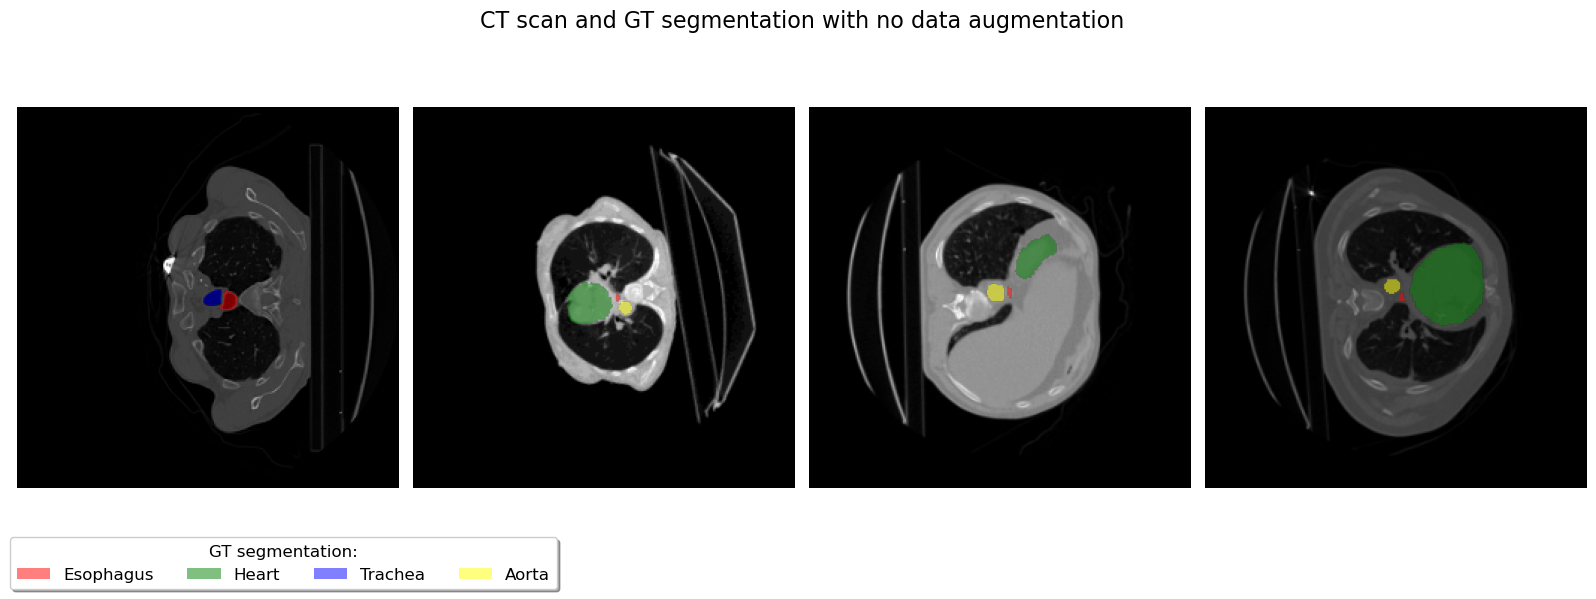

In [71]:
show_slices(batchgen, t="no")

## Plot augmentations

In [10]:
class AugmentationPipelinePlotter:
    """
    Defines the augmentation pipeline, which includes spatial transformations, noise, and contrast/brightness augmentations.
    """

    def __init__(self, target_patch_size, oversized_factor=1.2):
        self.target_patch_size = target_patch_size
        self.oversized_patch_size = (int(target_patch_size[0] * oversized_factor), int(target_patch_size[1] * oversized_factor))
    
        
    def get_rotation_transform(self):
        return RndTransform(SpatialTransform(
            patch_size=self.oversized_patch_size,
            patch_center_dist_from_border=np.array(self.oversized_patch_size) // 2,
            do_rotation=True,
            angle_x=(-0.174532925, 0.174532925),  # Rotate between -10 to +10 degrees on the z-axis

            # Disable all other transformations
            do_elastic_deform=False,  # Disable elastic deformation
            do_scale=False,  # Disable scaling
            random_crop=False,  # Disable random cropping (center crop is used by default)
            independent_scale_for_each_axis=False,  # Disable independent scaling

            # Border handling (to avoid artifacts when rotating)
            border_mode_data='constant',  # Handle borders by padding with constant values
            border_cval_data=0,  # Pad the image with 0 (black) outside its original boundaries
            order_data=1,  # Linear interpolation for smooth rotation
        ), prob=1)
    
    def get_scale_transform(self):
        return RndTransform(SpatialTransform(
            patch_size=self.oversized_patch_size,  # Output image patch size after padding
            patch_center_dist_from_border=np.array(self.oversized_patch_size) // 2,  # Center the patch

            # Enable rotation
            do_rotation=False,
            # Disable all other transformations
            do_elastic_deform=False,  # Disable elastic deformation
            do_scale=True,  # Disable scaling
            scale=(0.7, 1.4),  # Scale between 0.5 and
            random_crop=False,  # Disable random cropping (center crop is used by default)
            independent_scale_for_each_axis=True,  # Disable independent scaling

            # Border handling (to avoid artifacts when rotating)
            border_mode_data='constant',  # Handle borders by padding with constant values
            border_cval_data=0,  # Pad the image with 0 (black) outside its original boundaries
            order_data=1  # Linear interpolation for smooth rotation
        ), prob=1)


    def get_noise_transform(self):
        return GaussianNoiseTransform(
            noise_variance=(0, 0.1),
            p_per_sample=0.15  # Probability of applying noise
        )

    def get_blur_transform(self):
        return GaussianBlurTransform(
            blur_sigma=(0.5, 1.5),
            different_sigma_per_channel=True,
            p_per_sample=1,
            p_per_channel=0.5
        )

    def get_brightness_transform(self):
        return BrightnessMultiplicativeTransform(
            multiplier_range=(0.7, 1.3),
            p_per_sample=1
        )

    def get_contrast_transform(self):
        return ContrastAugmentationTransform(
            contrast_range=(0.65, 1.5),
            p_per_sample=1
        )

    # XXX
    def get_low_res_transform(self):
        return SimulateLowResolutionTransform(
            zoom_range=(1, 2),
            per_channel=True,
            p_per_sample=1,
            p_per_channel=0.5,
            order_downsample=0,
            order_upsample=3
        )

    def get_gamma_transform(self):
        return GammaTransform(
            gamma_range=(0.7, 1.5),
            invert_image=True,
            per_channel=True,
            retain_stats=True,
            p_per_sample=1,
        )

    def get_mirror_transform(self):
        return MirrorTransform(
            axes=(0, 1, 2),
            p_per_sample=1
        )

    def create_pipeline(self):
        """
        Create the full augmentation pipeline.
        """
        if self.type == 'rotation':
            return Compose([self.get_rotation_transform()])
        if self.type == 'scale':
            return Compose([self.get_scale_transform()])
        if self.type == 'noise':
            return Compose([self.get_noise_transform()])
        if self.type == 'blur':
            return Compose([self.get_blur_transform()])
        if self.type == 'brightness':
            return Compose([self.get_brightness_transform()])
        if self.type == 'contrast':
            return Compose([self.get_contrast_transform()])
        if self.type == 'low_res':
            return Compose([self.get_low_res_transform()])
        if self.type == 'gamma':
            return Compose([self.get_gamma_transform()])
        if self.type == 'mirror':
            return Compose([self.get_mirror_transform()])

    def create_data_generator(self, batchgen, type, num_processes=4, num_cached_per_queue=2):
        """
        Initialize a multi-threaded data generator with the augmentation pipeline.
        """
        self.type = type
        augmentation_pipeline = self.create_pipeline()
        
        # Create the multi-threaded augmenter
        return MultiThreadedAugmenter(
            batchgen,
            augmentation_pipeline,
            num_processes=num_processes,
            num_cached_per_queue=num_cached_per_queue,
        )
    


In [11]:
target_patch_size = img[0][0].shape  # Assuming HxW image
augmentation_pipeline = AugmentationPipelinePlotter(target_patch_size)


In [12]:
augmented_data_generator = augmentation_pipeline.create_data_generator(batchgen, type='rotation')

Rotation
In rotation
Compose ( [RndTransform( alternative_transform = None, transform = SpatialTransform( independent_scale_for_each_axis = False, p_rot_per_sample = 1, p_scale_per_sample = 1, p_el_per_sample = 1, data_key = 'data', label_key = 'seg', patch_size = (307, 307), patch_center_dist_from_border = array([153, 153]), do_elastic_deform = False, alpha = (0.0, 1000.0), sigma = (10.0, 13.0), do_rotation = True, angle_x = (-0.174532925, 0.174532925), angle_y = (0, 6.283185307179586), angle_z = (0, 6.283185307179586), do_scale = False, scale = (0.75, 1.25), border_mode_data = 'constant', border_cval_data = 0, order_data = 1, border_mode_seg = 'constant', border_cval_seg = 0, order_seg = 0, random_crop = False, p_rot_per_axis = 1, p_independent_scale_per_axis = 1 ), prob = 1 )] )


Batch shape: (4, 1, 307, 307)


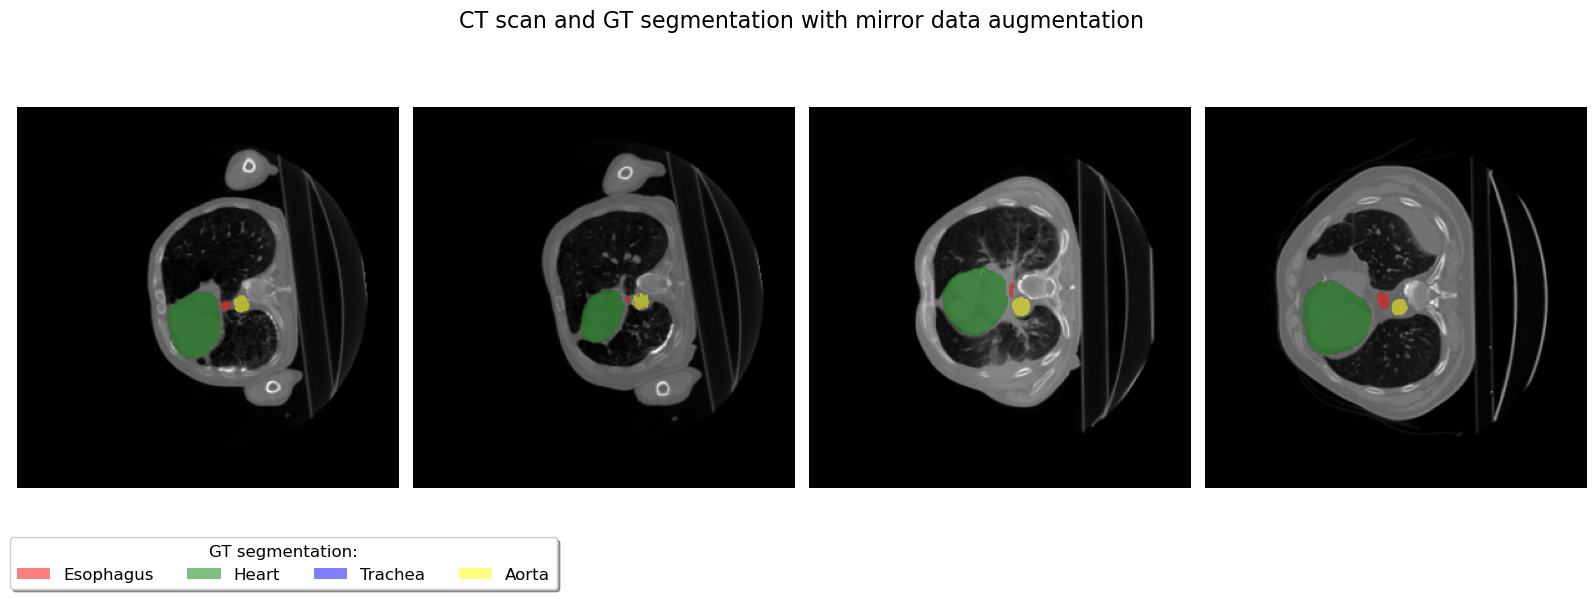

In [16]:
show_slices(augmented_data_generator, t = 'mirror')

Rotation
In rotation
Compose ( [RndTransform( alternative_transform = None, transform = SpatialTransform( independent_scale_for_each_axis = False, p_rot_per_sample = 1, p_scale_per_sample = 1, p_el_per_sample = 1, data_key = 'data', label_key = 'seg', patch_size = (307, 307), patch_center_dist_from_border = array([153, 153]), do_elastic_deform = False, alpha = (0.0, 1000.0), sigma = (10.0, 13.0), do_rotation = True, angle_x = (-0.174532925, 0.174532925), angle_y = (0, 6.283185307179586), angle_z = (0, 6.283185307179586), do_scale = False, scale = (0.75, 1.25), border_mode_data = 'constant', border_cval_data = 0, order_data = 1, border_mode_seg = 'constant', border_cval_seg = 0, order_seg = 0, random_crop = False, p_rot_per_axis = 1, p_independent_scale_per_axis = 1 ), prob = 1 )] )
Batch shape: (4, 1, 307, 307)


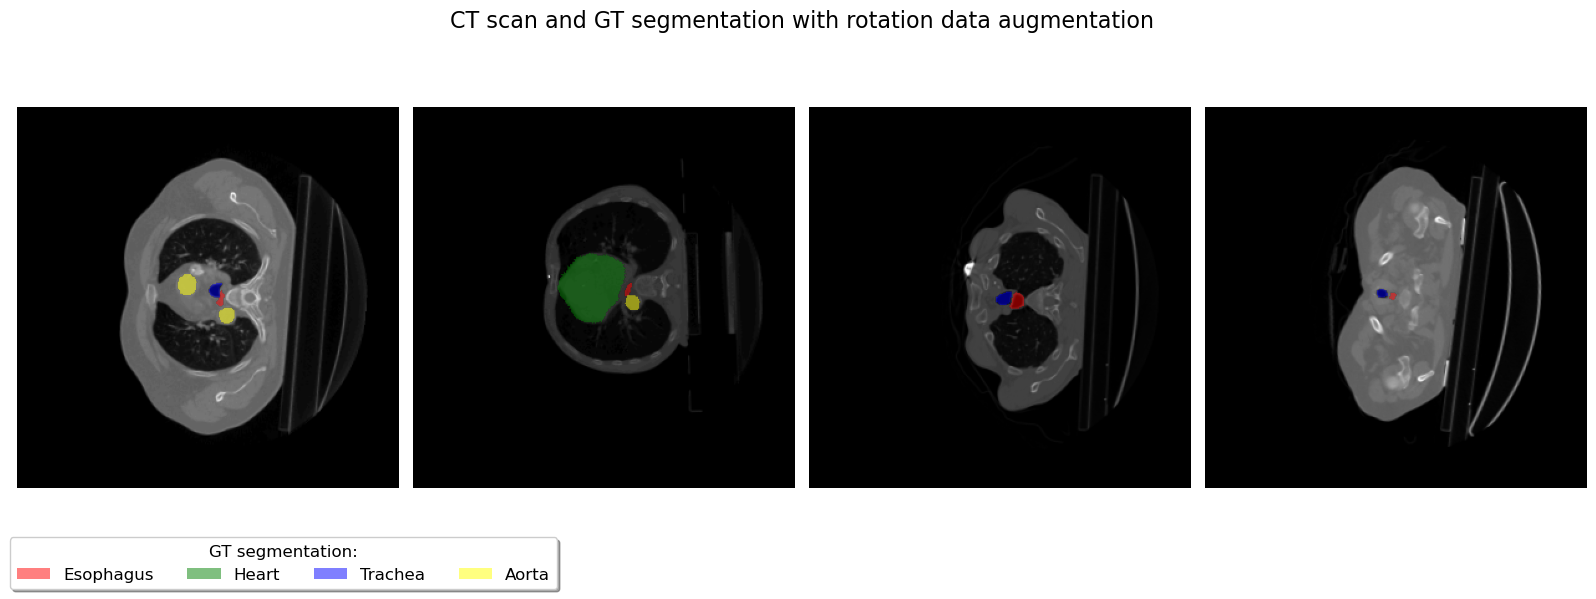

Compose ( [RndTransform( alternative_transform = None, transform = SpatialTransform( independent_scale_for_each_axis = True, p_rot_per_sample = 1, p_scale_per_sample = 1, p_el_per_sample = 1, data_key = 'data', label_key = 'seg', patch_size = (307, 307), patch_center_dist_from_border = array([153, 153]), do_elastic_deform = False, alpha = (0.0, 1000.0), sigma = (10.0, 13.0), do_rotation = False, angle_x = (0, 6.283185307179586), angle_y = (0, 6.283185307179586), angle_z = (0, 6.283185307179586), do_scale = True, scale = (0.7, 1.4), border_mode_data = 'constant', border_cval_data = 0, order_data = 1, border_mode_seg = 'constant', border_cval_seg = 0, order_seg = 0, random_crop = False, p_rot_per_axis = 1, p_independent_scale_per_axis = 1 ), prob = 1 )] )
Batch shape: (4, 1, 307, 307)


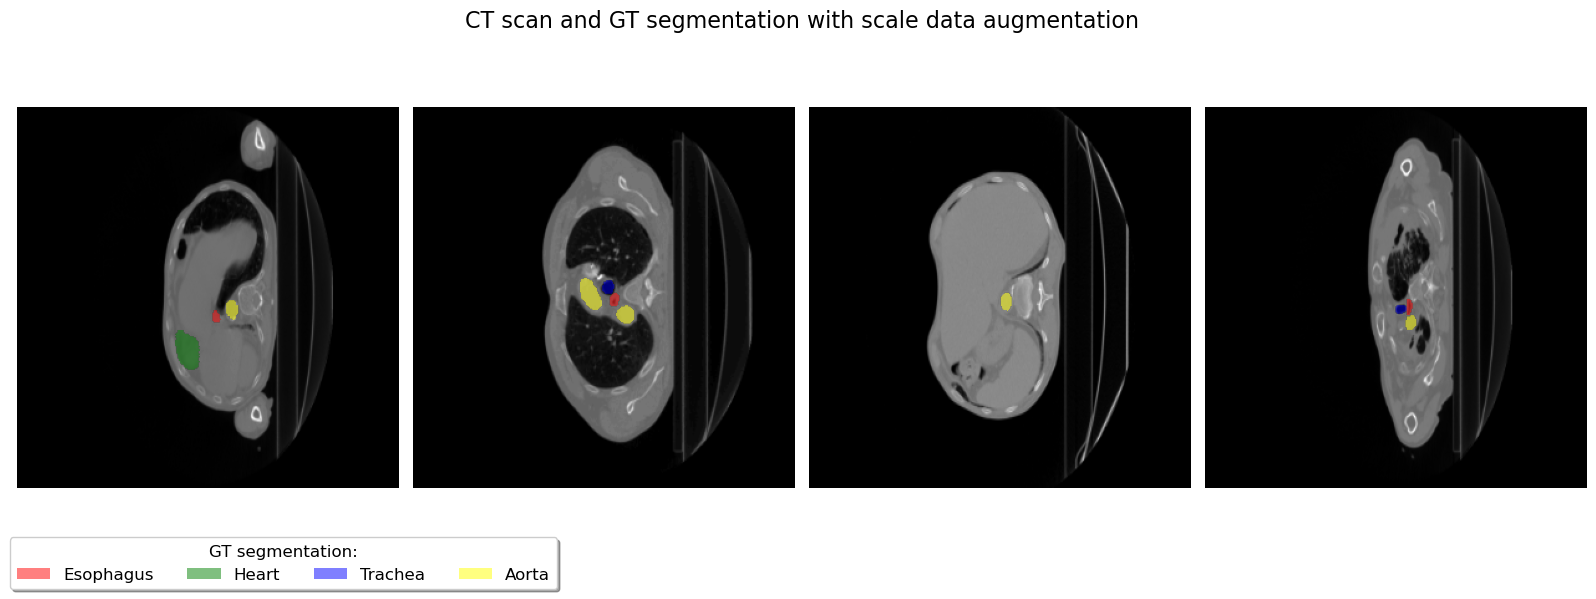

Compose ( [GaussianNoiseTransform( p_per_sample = 0.15, data_key = 'data', noise_variance = (0, 0.1), p_per_channel = 1, per_channel = False )] )
Batch shape: (4, 1, 256, 256)


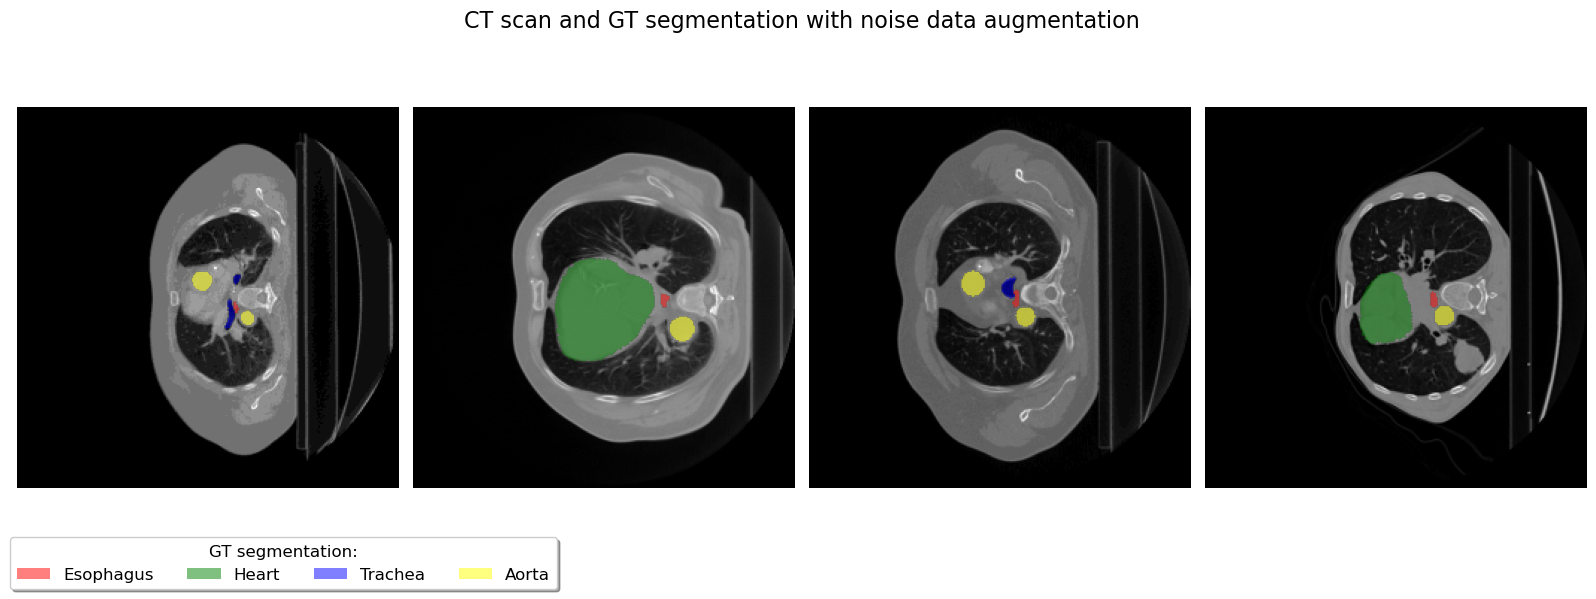

Compose ( [GaussianBlurTransform( p_per_sample = 1, different_sigma_per_channel = True, p_per_channel = 0.5, data_key = 'data', blur_sigma = (0.5, 1.5), different_sigma_per_axis = False, p_isotropic = 0 )] )
Batch shape: (4, 1, 256, 256)


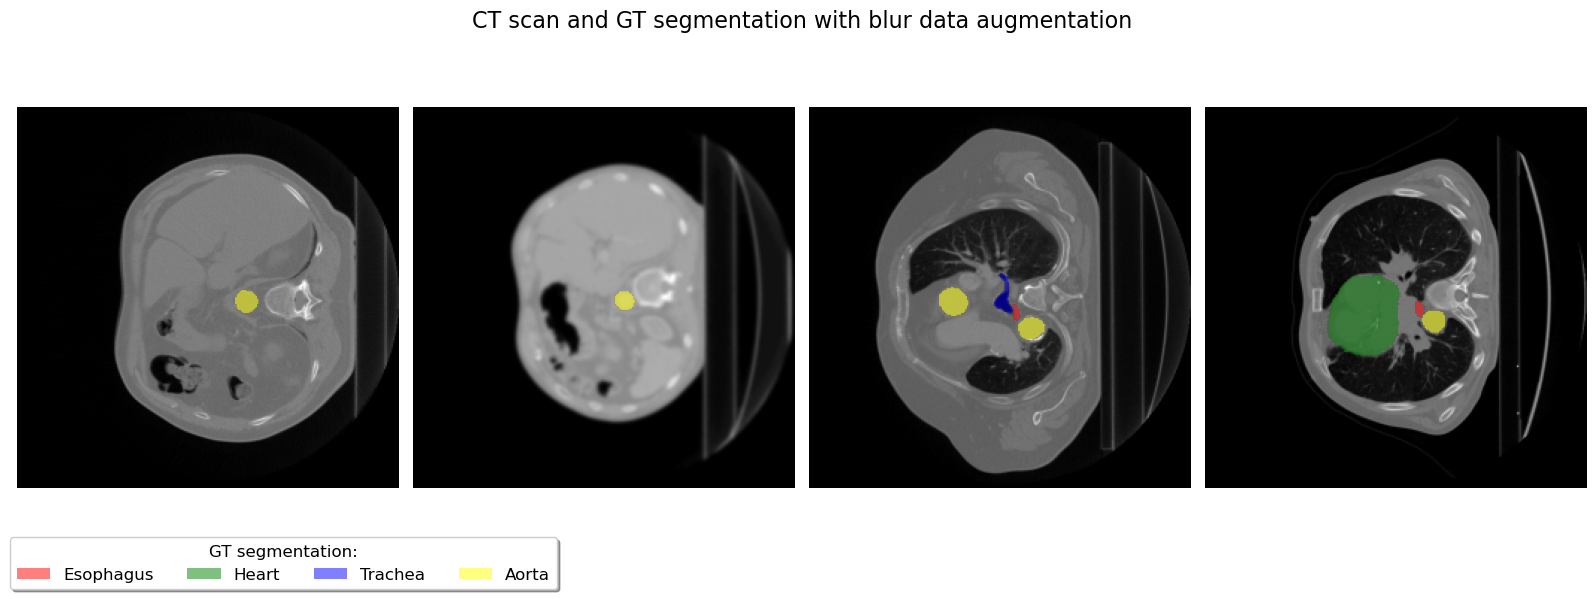

Compose ( [BrightnessMultiplicativeTransform( p_per_sample = 1, data_key = 'data', multiplier_range = (0.7, 1.3), per_channel = True )] )
Batch shape: (4, 1, 256, 256)


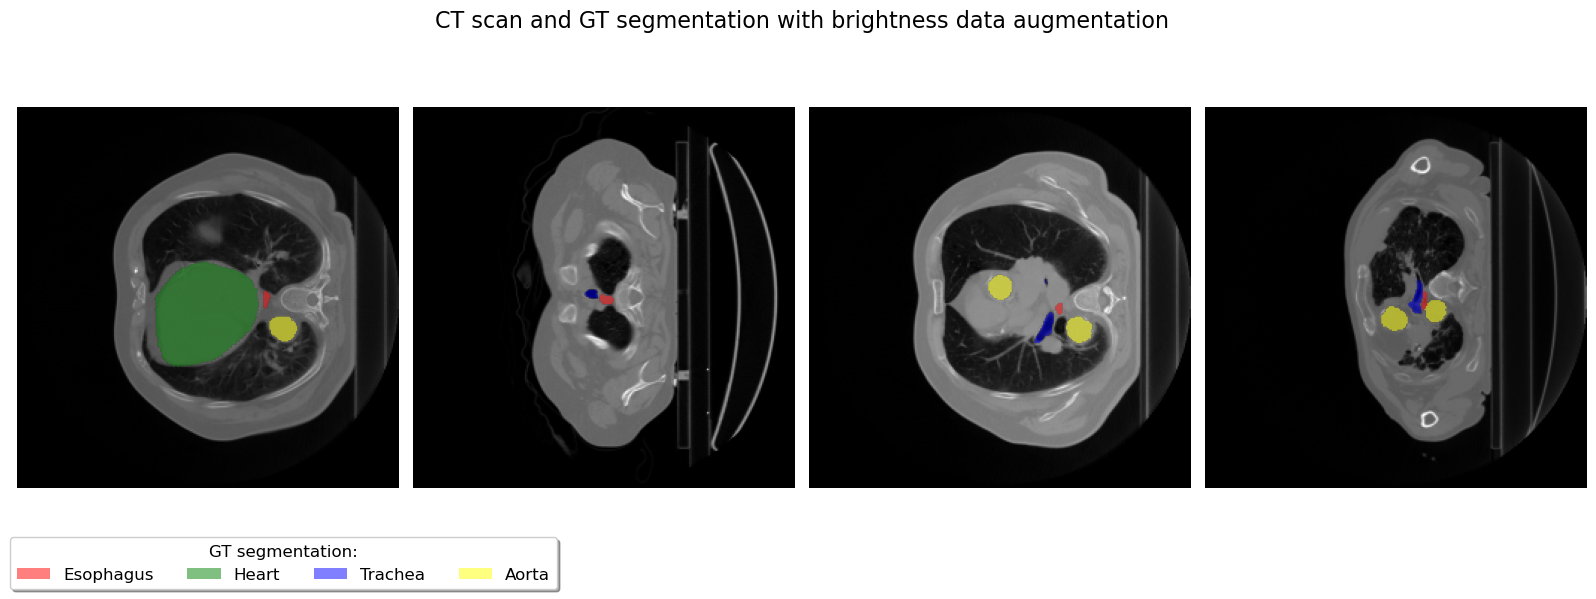

Compose ( [ContrastAugmentationTransform( p_per_sample = 1, data_key = 'data', contrast_range = (0.65, 1.5), preserve_range = True, per_channel = True, p_per_channel = 1 )] )
Batch shape: (4, 1, 256, 256)


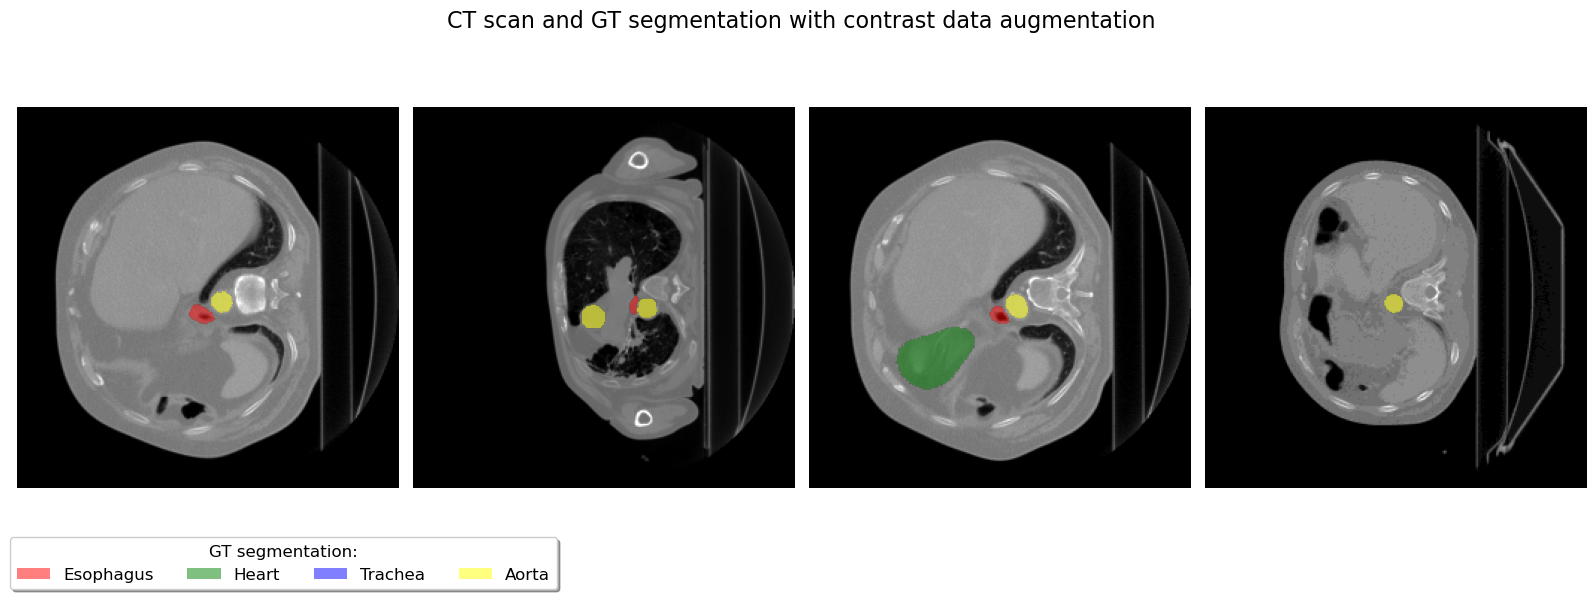

Compose ( [SimulateLowResolutionTransform( order_upsample = 3, order_downsample = 0, channels = None, per_channel = True, p_per_channel = 0.5, p_per_sample = 1, data_key = 'data', zoom_range = (1, 2), ignore_axes = None )] )
Batch shape: (4, 1, 256, 256)


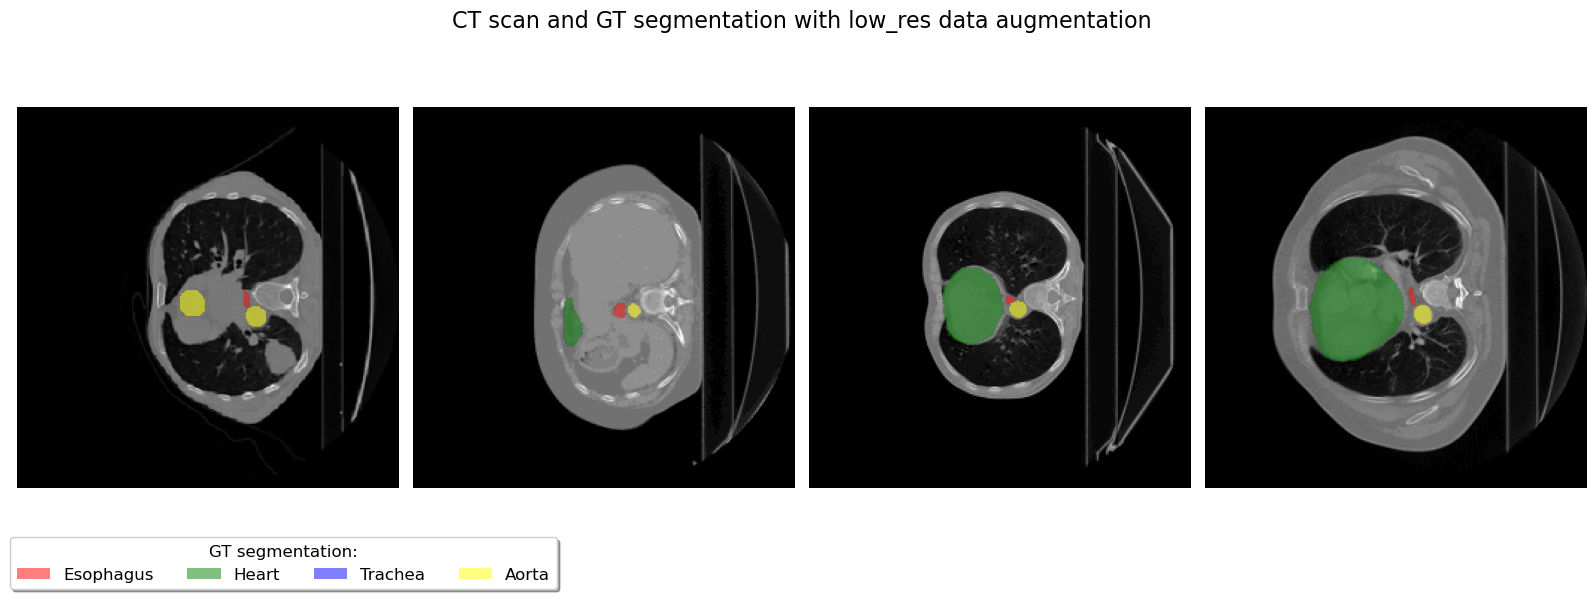

Compose ( [GammaTransform( p_per_sample = 1, retain_stats = True, per_channel = True, data_key = 'data', gamma_range = (0.7, 1.5), invert_image = True )] )
Batch shape: (4, 1, 256, 256)


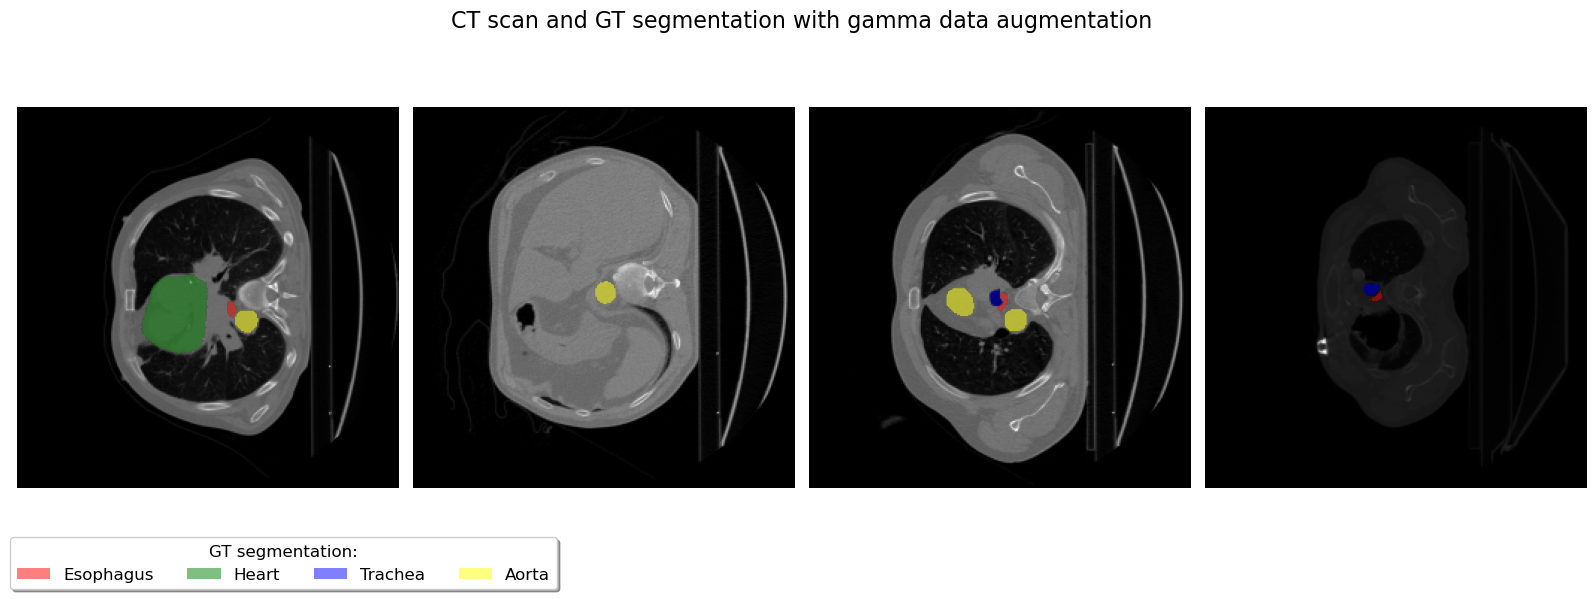

Compose ( [MirrorTransform( p_per_sample = 1, data_key = 'data', label_key = 'seg', axes = (0, 1, 2) )] )
Batch shape: (4, 1, 256, 256)


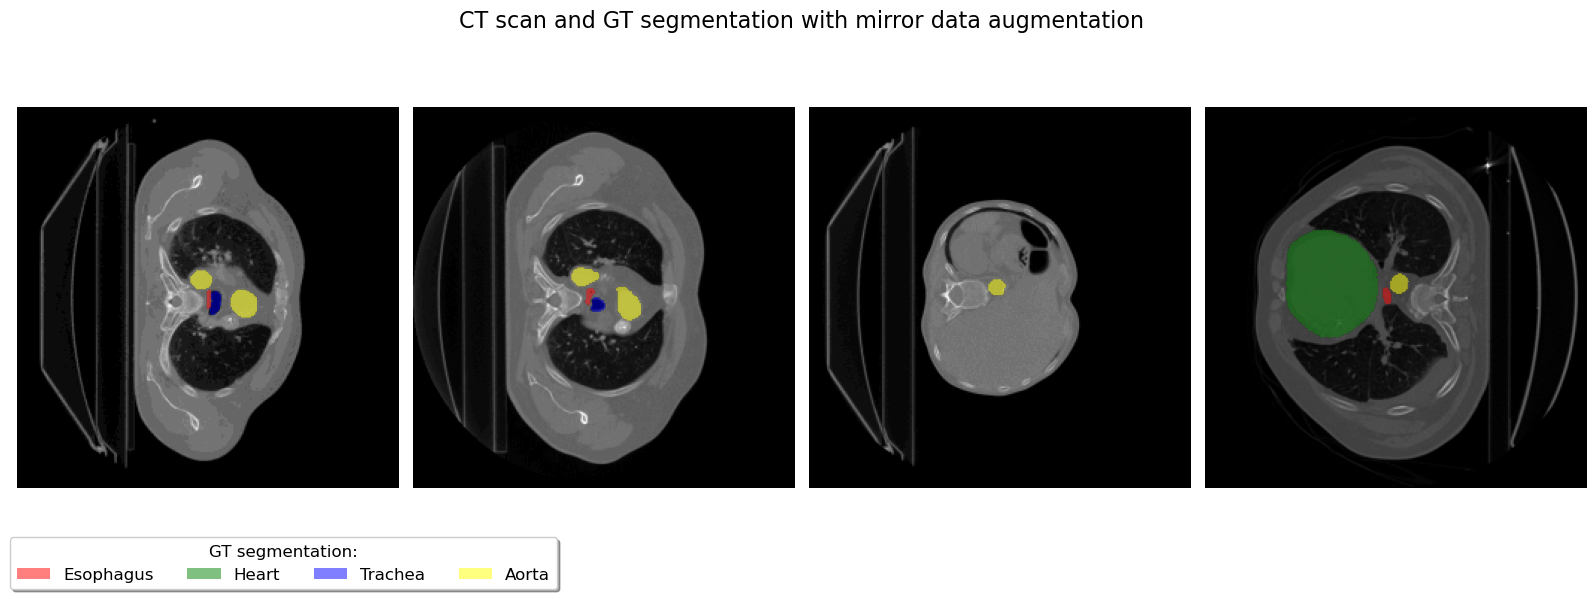

In [17]:
for t in ['rotation', 'scale', 'noise', 'blur', 'brightness', 'contrast', 'low_res', 'gamma', 'mirror']:
    augmented_data_generator = augmentation_pipeline.create_data_generator(batchgen, type = t)
    show_slices(augmented_data_generator, t = t)
    augmented_data_generator = None